# Heart Disease Exploration

DS100 Final Project, Spring 2020
Authors: Sophie Groenwold, Priyanka Banerjee

Our goal in this notebook is to use exploratatory data analysis to investigate our three questions of interest:
- What populations are represented in this dataset? (Section 1.2)
- To what extent can we accurately predict heart disease? (Section 1.4)
- Which features have the greatest influence in predicting whether or not an individual has heart disease? (Section 1.3 & 1.4)

In [1]:
# ***************************************************************
# For use with the confusion matrix in Section 1.4 of this notebook.
# Un-comment if necessary. 

# pip install seaborn

In [2]:
import numpy as np
import altair as alt
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sn

## Trying to use 1-4 target values

This was failed exploration, where we tried to use the 1 - 4 target values available in the original UCI Machine Learning Repository dataset with the rest of our features from Kaggle. The two datasets were not completely parallel, so this did not work out, and the target values of our final analysis are binary 0/1 values.

In [3]:
kaggle_df = pd.read_csv('heart.csv')
kaggle_df = kaggle_df.sort_values(by=['age'])
kaggle_df = kaggle_df.reset_index().drop('index', axis=1)

kaggle_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,29,1,1,130,204,0,0,202,0,0.0,2,0,2,1
1,34,1,3,118,182,0,0,174,0,0.0,2,0,2,1
2,34,0,1,118,210,0,1,192,0,0.7,2,0,2,1
3,35,1,0,126,282,0,0,156,1,0.0,2,0,3,0
4,35,0,0,138,183,0,1,182,0,1.4,2,0,2,1


In [4]:
cleveland_df = pd.read_csv('processed_cleveland.csv')
cleveland_df = cleveland_df.sort_values(by=['a'])
kaggle_df = kaggle_df.reset_index().drop('index', axis=1)

cleveland_df.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n
132,29.0,1.0,2.0,130.0,204.0,0.0,2.0,202.0,0.0,0.0,1.0,0.0,3.0,0
101,34.0,1.0,1.0,118.0,182.0,0.0,2.0,174.0,0.0,0.0,1.0,0.0,3.0,0
225,34.0,0.0,2.0,118.0,210.0,0.0,0.0,192.0,0.0,0.7,1.0,0.0,3.0,0
283,35.0,1.0,2.0,122.0,192.0,0.0,0.0,174.0,0.0,0.0,1.0,0.0,3.0,0
117,35.0,0.0,4.0,138.0,183.0,0.0,0.0,182.0,0.0,1.4,1.0,0.0,3.0,0


In [5]:
# to view all the range of values for each feature

for col in kaggle_df:
    print(kaggle_df[col].unique())
    
print('\n', "*********", '\n')

for col in cleveland_df:
    print(cleveland_df[col].unique())

[29 34 35 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 69 70 71 74 76 77]
[1 0]
[1 3 0 2]
[130 118 126 138 120 122 140  94 110 152 105 135 112 102 148 136 132 150
 115 108 128 142 104 101 124 134 129 144 125 100 172 123 160 192 180 200
 154 165 170 114 146 174 178 164 117 145 155 106 156]
[204 182 210 282 183 198 192 250 215 175 231 220 321 219 199 167 223 235
 306 214 157 203 268 172 226 265 244 240 295 209 180 315 177 341 247 211
 303 213 290 197 233 141 169 263 242 236 234 160 260 308 264 309 208 243
 311 249 257 275 253 255 229 256 274 222 245 271 269 266 188 149 254 196
 200 305 298 299 261 227 212 325 201 230 205 186 246 216 273 239 304 258
 232 288 267 206 283 286 342 262 353 327 217 289 193 409 184 221 294 354
 241 168 207 276 131 126 335 225 270 318 218 259 224 340 319 284 300 248
 176 326 293 178 185 307 330 166 164 394 281 187 252 195 407 313 417 360
 228 302 278 564 237 277 174 322]
[0 1]
[0 1 2]
[202 174 192 156 182 130 1

### Column counterparts

- age = a
- sex = b
- trestbps = d (but weird -- cleveland has an extra row)
- chol = e
- fbs = f
- thalach = h
- oldpeak = j

*kaggle values missing their counterpart:*
- cp
- restecg
- exang
- slope
- ca
- thal
- target (which is what we would've replaced)

*cleveland values missing their counterpart:*
- c
- g
- i
- k
- l
- m
- n (which is what we would've used in place of target)

Therefore, we can't stitch the two datasets together. 

## Population Exploration

Basic exploration of features, to aquaint ourselves with the format of the data; here is also where we explored the distribution of population-specific features, such as age and sex.

In [6]:
# number of patients with and without heart disease

print(kaggle_df[kaggle_df['target'] == 0].shape) # 138 without heart disease
print(kaggle_df[kaggle_df['target'] == 1].shape) # 165 with heart disease

(138, 14)
(165, 14)


In [7]:
# number of men and women

print(kaggle_df[kaggle_df['sex'] == 0].shape) #96 women
print(kaggle_df[kaggle_df['sex'] != 0].shape) #207 men

(96, 14)
(207, 14)


In [8]:
# exploring relationships between features

def plot_interactions(df,rows,columns, sze):
    '''
    make sure that the target color variable is called 'target'
    '''
    chart = alt.Chart(df).mark_circle(size = 50).encode(
        alt.X(alt.repeat("column"), type='quantitative'),
        alt.Y(alt.repeat("row"), type='quantitative'),
        color= alt.Color("target:N", scale=alt.Scale(scheme='set1'))
    ).properties(
        width=sze,
        height=sze
    ).repeat(
        row = rows,
        column = columns
    ).interactive()
    return chart

plot_interactions(kaggle_df, np.array(kaggle_df.columns), np.array(kaggle_df.columns), 150)

alt.RepeatChart(...)

In [9]:
# grouped bar plot to demonstrate the unequal target distribution by sex

kaggle_copy = kaggle_df.copy()

kaggle_copy = kaggle_copy.rename(columns={"sex": "Sex", "target": "Presence of Heart Disease"})
kaggle_copy['Sex'] = kaggle_copy['Sex'].map({0: 'female', 1: 'male'})
kaggle_copy['Presence of Heart Disease'] = kaggle_copy['Presence of Heart Disease'].map({0: 'false', 1: 'true'})

alt.Chart(kaggle_copy).mark_bar().encode(
    x='Presence of Heart Disease:O',
    y='count(Presence of Heart Disease):Q',
    color='Presence of Heart Disease:N',
    column='Sex:N'
).properties(
    width = 200,
    title = 'Presence of Heart Disease by Sex'
).configure_axis(
    labelFontSize = 13,
    titleFontSize = 15,
).configure_title(
    fontSize = 18
)

alt.Chart(...)

In [10]:
# violin plot of age for each target 

kaggle_copy_2 = kaggle_df.copy()

kaggle_copy_2 = kaggle_copy_2.rename(columns={"target": "Presence of Heart Disease"})
kaggle_copy_2['Presence of Heart Disease'] = kaggle_copy_2['Presence of Heart Disease'].map({0: 'false', 1: 'true'})

alt.Chart(kaggle_copy_2).transform_density(
    'age',
    as_=['age', 'density'],
    groupby=['Presence of Heart Disease']
).mark_area(orient='horizontal').encode(
    y='age:Q',
    color='Presence of Heart Disease:N',
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True),
    ),
    column=alt.Column(
        'Presence of Heart Disease:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0,
        ),
    )
).properties(
    width=200, 
    title = "Distribution of Age by Presence of Heart Disease"
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
).configure_axis(
    labelFontSize = 13,
    titleFontSize = 15,
).configure_title(
    fontSize = 15
)

alt.Chart(...)

---

## PCA

To investigate the impact of dimension reduction on our data, and to see the influence of each feature, we utilized PCA. This is following similar practices from lab06 and hw4.

In [11]:
# Z-score normalizing the data

kaggle_val = kaggle_df.drop('target', axis = 1).values
n = kaggle_val.shape[0]

kaggle_mean = np.mean(kaggle_val, axis = 0)
kaggle_mean
kaggle_sd = np.std(kaggle_val, axis = 0)
kaggle_sd
kaggle_centered = (kaggle_val - kaggle_mean) / (kaggle_sd)
kaggle_centered

array([[-2.7976235 ,  0.68100522,  0.03203122, ...,  0.97635214,
        -0.71442887, -0.51292188],
       [-2.24617937,  0.68100522,  1.97312292, ...,  0.97635214,
        -0.71442887, -0.51292188],
       [-2.24617937, -1.46841752,  0.03203122, ...,  0.97635214,
        -0.71442887, -0.51292188],
       ...,
       [ 2.16537369, -1.46841752,  0.03203122, ...,  0.97635214,
         0.26508221, -0.51292188],
       [ 2.38595135, -1.46841752,  1.00257707, ..., -0.64911323,
        -0.71442887, -0.51292188],
       [ 2.49624017,  0.68100522, -0.93851463, ...,  0.97635214,
         2.22410436, -0.51292188]])

In [12]:
# double-check that we normalized correctly

print(np.mean(kaggle_centered)) # should equal 0
print(np.var(kaggle_centered)) # should equal 1.0

-1.4250539762642274e-16
0.9999999999999999


In [13]:
# performing Singular Value Decomposition to assist in PCA

u, s, vt = np.linalg.svd(kaggle_centered, full_matrices=False)
u.shape, s, vt.shape

((303, 13),
 array([28.93435938, 21.57817595, 19.24886471, 18.91790396, 17.59704127,
        17.14394376, 16.16846585, 15.33334437, 14.75921501, 13.72354787,
        12.67366339, 11.32308003, 10.61479163]),
 (13, 13))

In [14]:
# find and compare total variance found from singular values

total_variance_singular_values = sum(np.square(s)) / len(kaggle_df)
print(total_variance_singular_values)

12.999999999999995


In [15]:
# variance explained by first singular value

variance_explained_by_1st_pc = (s[0]**2 / len(kaggle_centered)) / (total_variance_singular_values)
variance_explained_by_1st_pc

0.2125405312185195

In [16]:
# creating dataframe of variance explained by each PC

PC_num = []
i = 1
n = len(s)
while i <= n:
    PC_num.append(i)
    i += 1

explained_var = pd.DataFrame({
    'PC #': PC_num, 
    'Proportion of Variance Explained' : (s**2 / len(kaggle_centered)) / (total_variance_singular_values)
})

# making sure that the sum of PCs is approximately 1

print("sum of principal components: ", np.sum(explained_var['Proportion of Variance Explained']))

print('\n')

# viewing dataframe of variance explained by each PC
print(explained_var)

# scree plot of variance explained by each PC
alt.Chart(explained_var).mark_bar(size=30).encode(
    alt.X('PC #:O'),
    alt.Y('Proportion of Variance Explained:Q')
).properties(
    width=500,
    title = 'Scree Plot of Variance Explained by each PC'
).configure_axis(
    labelFontSize = 13,
    titleFontSize = 15,
).configure_title(
    fontSize = 18
)

sum of principal components:  1.0000000000000002


    PC #  Proportion of Variance Explained
0      1                          0.212541
1      2                          0.118207
2      3                          0.094064
3      4                          0.090857
4      5                          0.078613
5      6                          0.074617
6      7                          0.066367
7      8                          0.059688
8      9                          0.055302
9     10                          0.047813
10    11                          0.040777
11    12                          0.032549
12    13                          0.028605


alt.Chart(...)

In [17]:
# relationships between the first two PCs, viewed as a scatterplot

P = pd.DataFrame(u @ np.diag(s))
P = P.rename(columns={0: "PC1", 1: "PC2", 2: "PC3", 3: "PC4", 4: "PC5", 5: "PC6", 6: "PC7",
                     7: "PC8", 8: "PC9", 9: "PC10", 10: "PC11", 11: "PC12", 12: "PC13", 13: "PC14"})
P['target'] = kaggle_df['target']

alt.Chart(P).mark_circle().encode(
    x = "PC1",
    y = "PC2",
    color = alt.Color('target:N', scale=alt.Scale(scheme='set1'))
).properties(
    width=500,
    title = 'PC1 versus PC2 by Presence of Heart Disease'
).configure_axis(
    labelFontSize = 13,
    titleFontSize = 15,
).configure_title(
    fontSize = 18
)

alt.Chart(...)

In [18]:
# function to plot the contributions of each feature kaggle_df on our PCs

def plot_pc(col_names, vt, k):
    """ 
    Plot how much each column of our data contributes 
    to each principal component and labels the rows of V^T.
    """
    df = pd.DataFrame({'Contribution to Principal Component':vt[k, :], 'Feature':col_names})
    chart = alt.Chart(df).mark_bar().encode(
        x='Feature',
        y='Contribution to Principal Component',
    ).configure_axis(
        labelFontSize=12,
        titleFontSize=14
    ).configure_axisX(
        labelAngle = 0
    ).properties(
        width = 600,
        title = 'Contribution to PC by Feature'
    ).configure_axis(
        labelFontSize = 13,
        titleFontSize = 15,
    ).configure_title(
        fontSize = 18
    )
    return chart

In [19]:
# contribution of each feature for PC1
plot_pc(list(kaggle_df.drop('target', axis = 1).columns), vt, 0)

alt.Chart(...)

In [20]:
# contribution of each feature for PC2
plot_pc(list(kaggle_df.columns[:13]), vt, 1)

alt.Chart(...)

In [21]:
# contribution of each feature for PC3
plot_pc(list(kaggle_df.columns[:13]), vt, 2)

alt.Chart(...)

In [22]:
# contribution of each feature for PC4
plot_pc(list(kaggle_df.columns[:13]), vt, 3)

alt.Chart(...)

---

## Logistic Regression

We use a multivariable logistic regression to predict our binary `target` value. We incentivize the model to predict false positives over false negatives (since a false negative has a greater negative impact in a medical context than a false positive does) by using a `class_weight` split of 40% to 60%.

We then use a confusion matrix to determine the number of false negatives and false positives.

In [23]:
kaggle_df.columns[:13]

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [24]:
X = pd.DataFrame(kaggle_centered)
X.columns = kaggle_df.columns[:13]
y = kaggle_df['target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, stratify = y, random_state=0)
logreg = LogisticRegression(class_weight = ({0:0.4,1:0.6})).fit(X_train, y_train)

Testing Accuracy:  0.8421052631578947


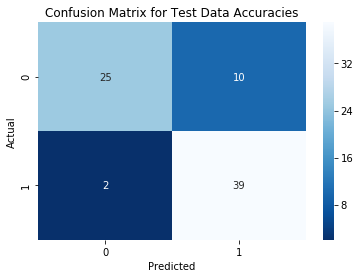

In [25]:
# with testing set:
#    making y_pred on testing set
y_pred=logreg.predict(X_test)

#    creating the confusion matrix for testing set
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap="Blues_r").set_title('Confusion Matrix for Test Data Accuracies')

#    using scikit-learn's accuracy score to determine testing set accuracy
print('Testing Accuracy: ',metrics.accuracy_score(y_test, y_pred))

Training Accuracy:  0.8502202643171806


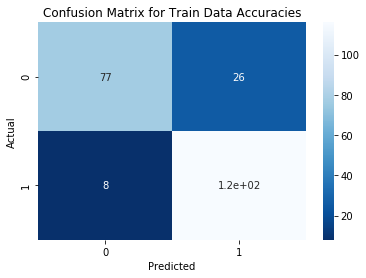

In [26]:
# with training set:
#    making y_pred on training set
y_pred_2=logreg.predict(X_train)

#    creating the confusion matrix for training set
confusion_matrix_2 = pd.crosstab(y_train, y_pred_2, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix_2, annot=True, cmap="Blues_r").set_title('Confusion Matrix for Train Data Accuracies')

#    using scikit-learn's accuracy score to determine training set accuracy
print('Training Accuracy: ',metrics.accuracy_score(y_train, y_pred_2))

In [27]:
# using the logistic regression model to find the weights for use in analyzing influence of each feature

logreg_df = pd.DataFrame({'Weights': logreg.coef_[0], 'Variables': X.columns})
logreg_df

alt.Chart(logreg_df).mark_bar().encode(
    x='Variables:N',
    y='Weights:Q',
    opacity=alt.value(0.7)
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).properties(
    width = 700,
    title = 'Impact of Each Predictor Variable in the Logistic Model'       
)

alt.Chart(...)